# Laboratory of Computational Physics mod.B

## Third assignment

### Group name: LoCPdown
### Components:
* Campesan Giulia (2027592)
* Faorlin Tommaso (2021857)
* Marcomini Alessandro (2024286)

### Objective:
The goal of this project is the analysis of various architectures of Convolutional Neural Networks (CNNs) and the characterization of how the usage of different layers and regularizations affects their performance. We worked on two datasets composed by 10000 sequences of 60 time steps. In both cases, the ultimate aim of the network is to perform a classification task. 

 

In [1]:
#import packages
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

np.random.seed(12345)

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix


## First dataset
### Loading and preparing data 

Here we focus on a known dataset in which a total of 10'000 samples are generated starting from a noisy sinusoidal signal. Some of them have been randomly modified by adding a positive or negative peak with a given intensity. As a result, data are classified in three classes (0: no peak, 1: positive peak, 2: negative peak). 

We import the datafile and proceed to renormalize the input to avoid gradient saturations.

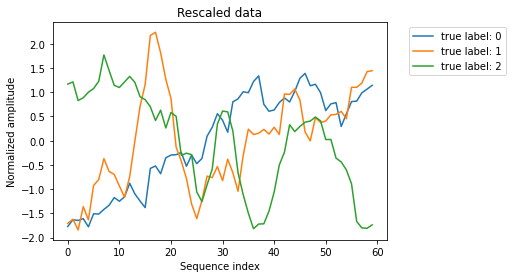


Total samples:  10000 
Training samples:  8000 
Test samples:  2000 
Sequence length:  60


In [2]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000'
fnamex = 'DATA/x_'+str0+'.csv'
fnamey = 'DATA/y_'+str0+'.csv'

x = np.loadtxt(fnamex, delimiter = ',', dtype = float)
N = len(x)

#removing mean and standard deviation from samples
xm = x.mean(axis = 1)
stdx = x.std(axis = 1)
for n in range(N):
    x[n] -= xm[n]
    x[n] /= stdx[n]
    
#one-hot encoding
categ = np.loadtxt(fnamey, delimiter = ',', dtype = int)
N_categ = np.max(categ)+1
y = np.zeros((N,N_categ))
for n in range(N):
    y[n][categ[n]] = 1  
    
    
    
plt.plot(x[0], label=('true label: ' + str(categ[0])))
plt.plot(x[1], label=('true label: ' + str(categ[1])))
plt.plot(x[2], label=('true label: ' + str(categ[2])))
plt.title('Rescaled data')
plt.ylabel('Normalized amplitude')
plt.xlabel('Sequence index')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()    


perc_train = 0.8                    
N_train = int(N*perc_train)
N_val = N - N_train

x_train, y_train = x[:N_train], y[:N_train]
x_val, y_val = x[N_train:], y[N_train:]

print('\nTotal samples: ', N,
      '\nTraining samples: ', N_train,
      '\nTest samples: ', N_val,
      '\nSequence length: ', len(x[0])
     )

#reshaping
x_train = x_train.reshape(x_train.shape[0],len(x[0]),1)
x_val = x_val.reshape(x_val.shape[0],len(x[0]),1)
input_shape = (len(x[0]),1)

### Network architecture

We now define the network to analyze our data: we create it with two convolutional layers of 5 filters each, with dimention 11 and 7 respectively, and an average pooling over 5 entries between them. The CNN is followed by a fully-connected neural network made of two layers of size 10 and 3, respectively. The last one is the output layer with softmax activation function to return the probabilities linked to each category. All other activation functions are set as ReLU.

In [3]:
#Ridge, lambda = 10**-2
reg = regularizers.l2(0.01)    
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)

model = Sequential()
model.add(Conv1D(                                       
                filters = 5,
                kernel_size = 11,                      
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                )
         )
model.add(AveragePooling1D(5))                          
model.add(Conv1D(                                       
                filters = 5,
                kernel_size = 7,
                activation = 'relu'
                )
         )
model.add(Flatten())                                      
model.add(Dense(10,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(N_categ,activation = 'softmax'))

print(model.summary())   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d (AveragePo (None, 10, 5)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 5)              180       
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [4]:
model.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam',
              metrics = ['accuracy']
             )

#after a compilation of the network we save in 'initial.h5' the weight at the beginning
model.save_weights('initial.h5')

In [5]:
batch_size = 250
epochs = 250

fit = model.fit(x_train,
                y_train,
                batch_size = batch_size,
                epochs = epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

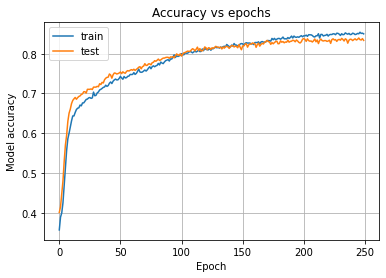

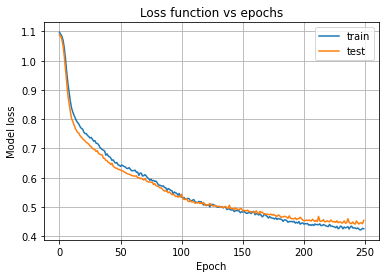

In [6]:
# accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('Accuracy vs epochs')
plt.ylabel('Model accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

# loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Loss function vs epochs')
plt.ylabel('Model loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

As we can infer the model reaches similar accuracies over the training and test sets ($\sim 85\%$). Therefore, we can conclude that no overfitting is performed and the plateau at the end of the learning curves allows us to see how 250 epochs are enough to reach covergence. 

### Confusion matrix and signal-noise-ratio variation

In order to see how different labels are eventually confused, we plot the confusion matrix of the model we trained. As we can see the correspondence between true and predicted labels (diagonal elements) is pretty good and the most mistaken label is '0', which seems reasonable given the possible confusion with both positive and negative peaks. 

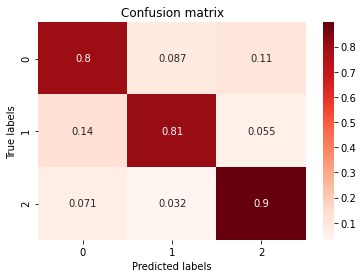

In [7]:
y_pred_val  = model.predict(x_val)

#take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)
confusion_Oz = confusion_matrix(max_y_pred_val,max_y_val, normalize='true') 
sns.heatmap(confusion_Oz, annot = True, cmap = plt.cm.Reds, fmt = '.2g')

plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion matrix')
plt.show()

Now we change the "A" parameter (i.e., the amplitude of the signal) in order to study the behaviour of the classifier when the noise presence is changing in the signal. We explore values of "A" between 50 and 600.

100%|██████████| 12/12 [08:27<00:00, 42.31s/it]


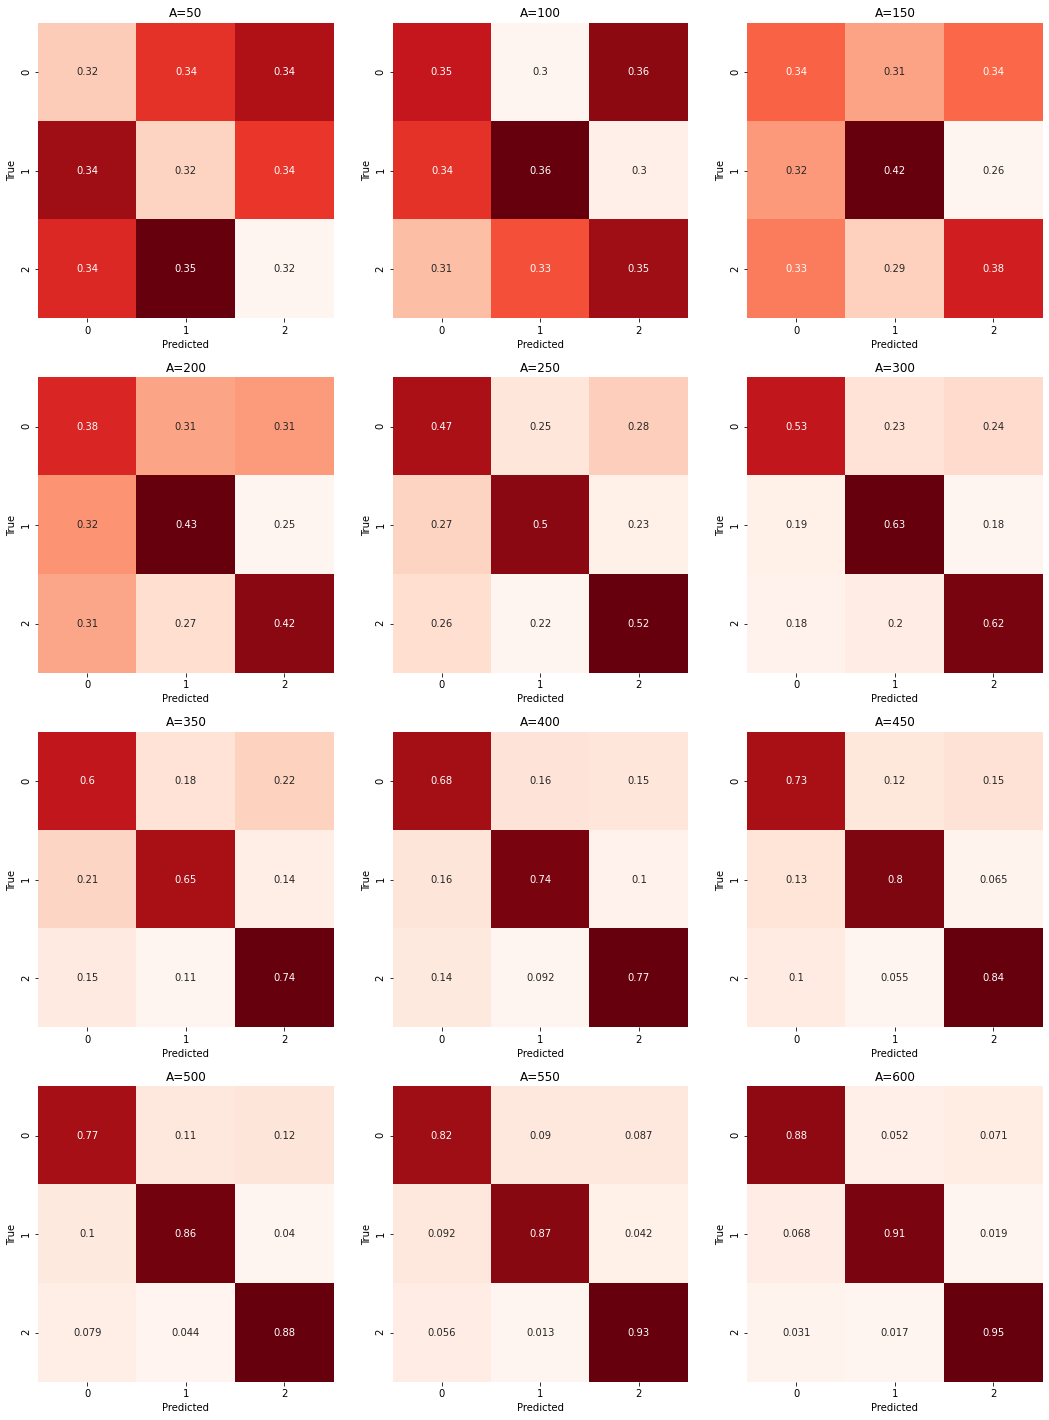

In [8]:
from tqdm import tqdm

fig, ax = plt.subplots(4, 3, figsize=(18,25))
As = np.arange(50,650,50)
scores = {}

for a in tqdm(range(len((As)))):
    
    #if statements to define the grid for the subplots
    if a < 3:
        i = 0
        j = a
    elif a < 6:
        i = 1
        j = a-3
    elif a < 9:
        i = 2
        j = a-6
    elif a < 12:
        i = 3
        j = a-9
    elif a < 15:
        i = 4
        j = a-12
    
    str0 = f'ts_L60_Z12_A{As[a]}_DX50_bias5_N10000'
    fnamex = 'DATA/x_'+str0+'.csv'
    fnamey = 'DATA/y_'+str0+'.csv'
    
    x = np.loadtxt(fnamex, delimiter = ',', dtype = float)
    N = len(x)

    xm = x.mean(axis = 1)
    stdx = x.std(axis = 1)
    for n in range(N):
        x[n] -= xm[n]
        x[n] /= stdx[n]

    categ = np.loadtxt(fnamey, delimiter = ',', dtype = int)
    N_categ = np.max(categ)+1
    y = np.zeros((N,N_categ))
    for n in range(N):
        y[n][categ[n]] = 1             

    perc_train = 0.8                    
    N_train = int(N*perc_train)
    N_val = N - N_train

    x_train, y_train = x[:N_train], y[:N_train]
    x_val, y_val = x[N_train:], y[N_train:]

    L = len(x[0])

    x_train = x_train.reshape(x_train.shape[0],L,1)   
    x_val = x_val.reshape(x_val.shape[0],L,1)
    input_shape = (L,1)
    
    #at each step of the for loop we recover the initial weights in order to start always from the same model
    model.load_weights('initial.h5')
    fit = model.fit(x_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (x_val,y_val),
                    verbose = 0
                   )
    scores[As[a]] = np.mean(fit.history['accuracy'][-20:])
    
    y_pred_val  = model.predict(x_val)
    max_y_pred_val = np.argmax(y_pred_val, axis=1)
    max_y_val = np.argmax(y_val, axis=1)
    confusion_Oz = confusion_matrix(max_y_pred_val,max_y_val, normalize='true') 
 
    g = sns.heatmap(confusion_Oz,
                    annot = True,
                    cmap = plt.cm.Reds,
                    cbar = False,
                    fmt = '.2g',
                    ax = ax[i][j]
                   )
    g.set_ylabel('True')
    g.set_xlabel('Predicted')
    g.set_title(f'A={As[a]}')

plt.show()

The result is clear: a higher signal to noise ratio (that we achieved by increasing the amplitude of the signal A from 50 to 600) results in a better confusion matrix. In fact, if we compare the first $A=50$ and the last $A=600$ matrices, we see how the percentage values along the diagonal are higher in the second case, while in the first case labels were attributed completely randomly.

The following plot summarizes this behaviour: we see how the test accuracy grows with a cleaner signal (bigger "A"), as expected.

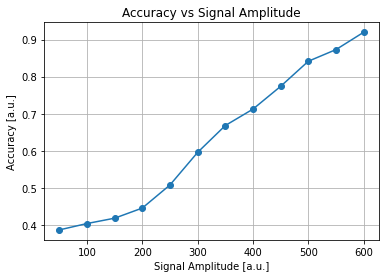

In [9]:
keys_int = []
as_accuracy = []
for k in scores.keys():
    keys_int.append(k)
    as_accuracy.append(scores.get(k))
    
plt.plot(keys_int, as_accuracy, '-o')

plt.title('Accuracy vs Signal Amplitude')
plt.xlabel('Signal Amplitude [a.u.]')
plt.ylabel('Accuracy [a.u.]')

plt.grid()
plt.show()

## Second dataset
### Loading and rescaling data

We now switch to dataset "ts_comp_N10000", where an unknown generation of signals occurs. 

In [10]:
str1 = 'ts_comp_N10000'
fnamex1 = 'DATA/x_'+str1+'.csv'
fnamey1 = 'DATA/y_'+str1+'.csv'

x = np.loadtxt(fnamex1, delimiter = ',', dtype = float)
categ = np.loadtxt(fnamey1, delimiter = ',', dtype = int)

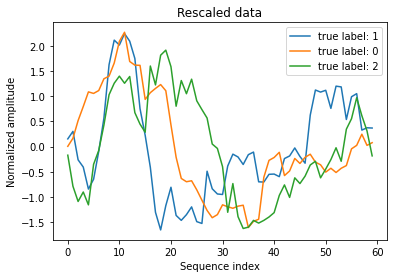


Total samples:  10000 
Training samples:  8000 
Test samples:  2000 
Sequence length:  60


In [11]:
N = len(x)

xm = x.mean(axis = 1)
stdx = x.std(axis = 1)
for n in range(N):
    x[n] -= xm[n]
    x[n] /= stdx[n]
    
plt.plot(x[0], label=('true label: ' + str(categ[0])))
plt.plot(x[1], label=('true label: ' + str(categ[1])))
plt.plot(x[2], label=('true label: ' + str(categ[2])))
plt.xlabel('Sequence index')
plt.ylabel('Normalized amplitude')
plt.title('Rescaled data')
plt.legend()
plt.show()    

#one-hot encoding
N_categ = np.max(categ)+1
y = np.zeros((N,N_categ))
for n in range(N):
    y[n][categ[n]] = 1             

perc_train = 0.8                    
N_train = int(N*perc_train)
N_val = N - N_train

x_train, y_train = x[:N_train], y[:N_train]
x_val, y_val = x[N_train:], y[N_train:]

print('\nTotal samples: ', N,
      '\nTraining samples: ', N_train,
      '\nTest samples: ', N_val,
      '\nSequence length: ', len(x[0])
     )

x_train = x_train.reshape(x_train.shape[0],len(x[0]),1)  
x_val = x_val.reshape(x_val.shape[0],len(x[0]),1)
input_shape = (len(x[0]),1)

### Testing different architectures

Henceforth, we keep just one Conv1D layer and we see what happens when adding more and more Dense layers to the final fully-connected NN with the constraing of keeping the number of trainable parameters below 600. The architecture of the CNN up to the first Dense layer will be always the same: we did this in order to extract a common based behaviour among the models. All the architectures are summarized in the following cells.

In [12]:
#Ridge, lambda = 10**-2
reg = regularizers.l2(0.01)    
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)

batch_size = 250
epochs = 250

##### Basic architecture

In [13]:
np.random.seed(12345)
model1 = Sequential()
model1.add(Conv1D(                                       
                filters = 5,
                kernel_size = 6,                      
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))
model1.add(AveragePooling1D(5))                          
model1.add(Flatten())            

#1xDense layer
model1.add(Dense(8,activation = 'relu'))

model1.add(Dropout(0.1))
model1.add(Dense(N_categ,activation = 'softmax'))

print(model1.summary()) 
model1.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count1 = count_params(model1.trainable_weights)

fit1 = model1.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

fname ='MODEL/model1.h5'
model1.save(fname, save_format='h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 55, 5)             35        
_________________________________________________________________
average_pooling1d_1 (Average (None, 11, 5)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 55)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 448       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 510
Trainable params: 510
Non-trainable params: 0
________________________________________________________

##### Basic architecture + 1 Dense layer

In [14]:
np.random.seed(12345)
model2 = Sequential()
model2.add(Conv1D(                                       
                filters = 5,
                kernel_size = 6,                       
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))
model2.add(AveragePooling1D(5))                          
model2.add(Flatten())         

#2xDense layer
model2.add(Dense(8,activation = 'relu'))
model2.add(Dense(6,activation = 'relu'))

model2.add(Dropout(0.2))
model2.add(Dense(N_categ,activation = 'softmax'))

print(model2.summary()) 

model2.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count2 = count_params(model2.trainable_weights)

fit2 = model2.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

fname ='MODEL/model2.h5'
model2.save(fname, save_format='h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 55, 5)             35        
_________________________________________________________________
average_pooling1d_2 (Average (None, 11, 5)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 55)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 448       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 54        
_________________________________________________________________
dropout_2 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                

##### Basic architecture + 2 Dense layers

In [15]:
np.random.seed(12345)
model3 = Sequential()
model3.add(Conv1D(                                       
                filters = 5,
                kernel_size = 6,                       
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))
model3.add(AveragePooling1D(5))                          
model3.add(Flatten()) 

#3xDense layer
model3.add(Dense(8,activation = 'relu'))
model3.add(Dense(6,activation = 'relu'))
model3.add(Dense(3,activation = 'relu'))

model3.add(Dropout(0.2))
model3.add(Dense(N_categ,activation = 'softmax'))

print(model3.summary()) 

model3.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count3 = count_params(model3.trainable_weights)

fit3 = model3.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

fname ='MODEL/model3.h5'
model3.save(fname, save_format='h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 55, 5)             35        
_________________________________________________________________
average_pooling1d_3 (Average (None, 11, 5)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 55)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 448       
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 21        
_________________________________________________________________
dropout_3 (Dropout)          (None, 3)                

In [16]:
np.random.seed(12345)
model4 = Sequential()
model4.add(Conv1D(                                       
                filters = 5,
                kernel_size = 6,                       
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                )
          )
model4.add(AveragePooling1D(5))                          
model4.add(Flatten())          

#4xDense layer
model4.add(Dense(8,activation = 'relu'))
model4.add(Dense(6,activation = 'relu'))
model4.add(Dense(3,activation = 'relu'))
model4.add(Dense(3,activation = 'relu'))

model4.add(Dropout(0.2))
model4.add(Dense(N_categ,activation = 'softmax'))

print(model4.summary()) 

model4.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count4 = count_params(model4.trainable_weights)

fit4 = model4.fit(x_train,
                  y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data = (x_val,y_val),
                  verbose = 0
                   )

fname ='MODEL/model4.h5'
model4.save(fname, save_format='h5')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 55, 5)             35        
_________________________________________________________________
average_pooling1d_4 (Average (None, 11, 5)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 55)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 448       
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_14 (Dense)             (None, 3)                

##### Basic architecture + 3 Dense layers

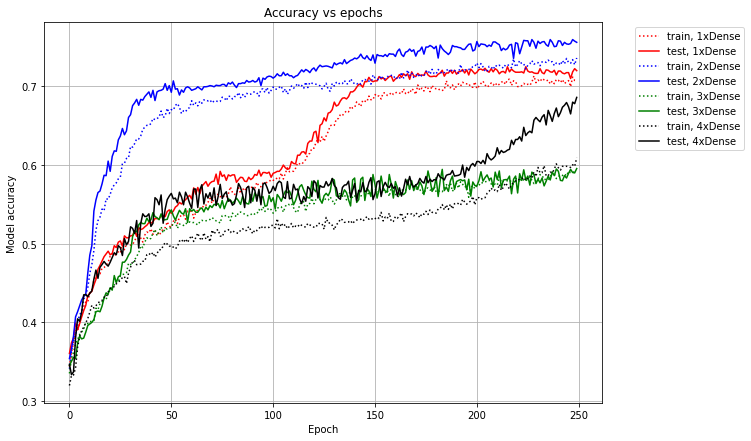

In [135]:
plt.figure(figsize=(10,7))

plt.plot(fit1.history['accuracy'], label='train, 1xDense', c='r', ls='dotted')
plt.plot(fit1.history['val_accuracy'], label='test, 1xDense', c='r')
plt.plot(fit2.history['accuracy'], label='train, 2xDense', c='b', ls='dotted')
plt.plot(fit2.history['val_accuracy'], label='test, 2xDense', c='b')
plt.plot(fit3.history['accuracy'], label='train, 3xDense', c='g', ls='dotted')
plt.plot(fit3.history['val_accuracy'], label='test, 3xDense', c='g')
plt.plot(fit4.history['accuracy'], label='train, 4xDense', c='black', ls='dotted')
plt.plot(fit4.history['val_accuracy'], label='test, 4xDense', c='black')

plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Accuracy vs epochs')
plt.ylabel('Model accuracy')
plt.xlabel('Epoch')
plt.grid()

plt.show()

As we can observe adding Dense layers does not lead to better performances. The optimal overall is the one with two additional Dense layers.

Now we fix the number of Dense layers based on the best model obtained in the last trials. As we can see from the graph just above, the model with just one Dense layer is the one with the best performance. We now add, before the Dense layer one Conv1D (model5) and two Conv1D (model6) in order to see how the total number of parameters scale. We will collect the results in a dataframe below.

##### Basic architecture + 1 Convolutional layer


In [18]:
np.random.seed(12345)

model5 = Sequential()
model5.add(Conv1D(                                 
                filters = 5,
                kernel_size = 6,
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))

model5.add(AveragePooling1D(5))

model5.add(Conv1D(filters=5, kernel_size=6, activation='relu'))

model5.add(Flatten())                                    
model5.add(Dense(8,activation = 'relu'))
model5.add(Dropout(0.2))
model5.add(Dense(N_categ,activation = 'softmax'))

print(model5.summary()) 

model5.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count5 = count_params(model5.trainable_weights)

fit5 = model5.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )


fname ='MODEL/model5.h5'
model5.save(fname, save_format='h5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 55, 5)             35        
_________________________________________________________________
average_pooling1d_5 (Average (None, 11, 5)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 6, 5)              155       
_________________________________________________________________
flatten_5 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 248       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                

##### Basic architecture + 2 Convolutional layers

In [19]:
np.random.seed(12345)

model6 = Sequential()
model6.add(Conv1D(                                       
                filters = 5,
                kernel_size = 6,                       
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))

model6.add(AveragePooling1D(5)) 

model6.add(Conv1D(filters=5,
                  kernel_size=6,
                  activation='relu')
          )

model6.add(Conv1D(filters=5,
                  kernel_size=4,
                  activation='relu')
          )

model6.add(Flatten())                                     
model6.add(Dense(8,activation = 'relu'))
model6.add(Dropout(0.2))
model6.add(Dense(N_categ,activation = 'softmax'))

print(model6.summary()) 

model6.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count6 = count_params(model6.trainable_weights)

fit6 = model6.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )


fname ='MODEL/model6.h5'
model6.save(fname, save_format='h5')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 55, 5)             35        
_________________________________________________________________
average_pooling1d_6 (Average (None, 11, 5)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 6, 5)              155       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 3, 5)              105       
_________________________________________________________________
flatten_6 (Flatten)          (None, 15)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                

Here we plot the best performing architecture with multiple Dense layers (2) and the cases in which we added Convolutional ones. We observe that the performances are comparable. 

<ipython-input-26-5fd0c24b1a4b>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


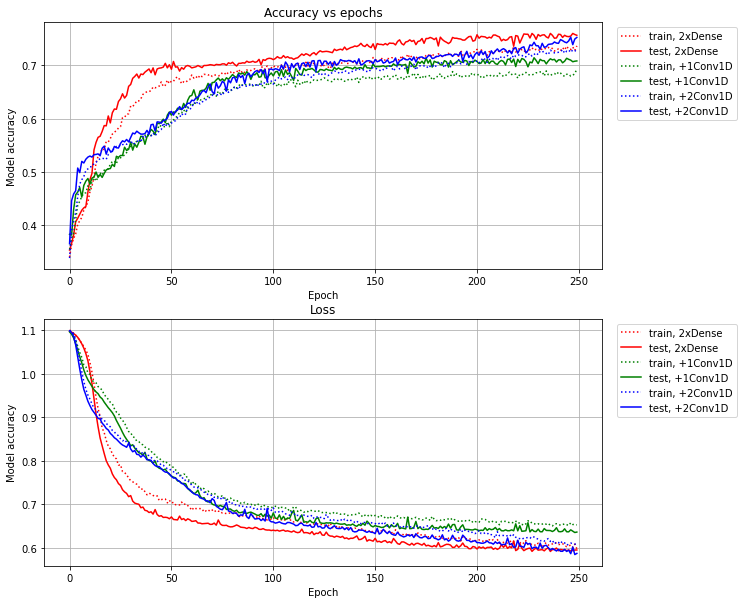

In [26]:
# look into training history
import matplotlib.pyplot as plt
plt, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].plot(fit2.history['accuracy'], label='train, 2xDense', c='r', linestyle='dotted')
ax[0].plot(fit2.history['val_accuracy'], label='test, 2xDense', c='r')
ax[0].plot(fit5.history['accuracy'], label='train, +1Conv1D', c='g', linestyle='dotted')
ax[0].plot(fit5.history['val_accuracy'], label='test, +1Conv1D', c='g')
ax[0].plot(fit6.history['accuracy'], label='train, +2Conv1D', c='b', linestyle='dotted')
ax[0].plot(fit6.history['val_accuracy'], label='test, +2Conv1D', c='b')

ax[0].set_title('Accuracy vs epochs')
ax[0].set_ylabel('Model accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(bbox_to_anchor=(1.25, 1))
ax[0].grid()


ax[1].plot(fit2.history['loss'], label='train, 2xDense', c='r', linestyle='dotted')
ax[1].plot(fit2.history['val_loss'], label='test, 2xDense', c='r')
ax[1].plot(fit5.history['loss'], label='train, +1Conv1D', c='g', linestyle='dotted')
ax[1].plot(fit5.history['val_loss'], label='test, +1Conv1D', c='g')
ax[1].plot(fit6.history['loss'], label='train, +2Conv1D', c='b', linestyle='dotted')
ax[1].plot(fit6.history['val_loss'], label='test, +2Conv1D', c='b')

ax[1].set_title('Loss')
ax[1].set_ylabel('Model accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(bbox_to_anchor=(1.25, 1))
ax[1].grid()

plt.show()

### Summary

In [21]:
import pandas as pd
df = pd.DataFrame()
convs = np.array([1, 1, 1, 1, 2, 3])
denses = np.array([1, 2, 3, 4, 1, 1])
trainable_count = np.array([trainable_count1,
                            trainable_count2,
                            trainable_count3,
                            trainable_count4,
                            trainable_count5,
                            trainable_count6
                           ]
                          )

df['Convolutional layers'] = convs
df['Dense layers'] = denses
df['Trainable parameters'] = trainable_count

print(df)

,Convolutional layers,Dense layers,Trainable parameters
0,1,1,510
1,1,2,558
2,1,3,570
3,1,4,582
4,2,1,465
5,3,1,450


Fixed our base architecture, we can see from this dataframe that the number of total parameters increase more rapidly when we add Dense layers rather than convolutional. This is related to how a convolutional filter works and depends obviously on the number of filters and the kernel size (that we fixed before this reasoning as we have said).

## Regularization 

We now analyze how regularization affects convergence and weights evolution. We explore a $\lambda$ range of (0.001, 0.01, 0.1, 1, 10) and Ridge, Lasso and Mixed loss functions. We select as architecture a three-layers convolutional model.

100%|██████████| 15/15 [11:33<00:00, 46.20s/it]


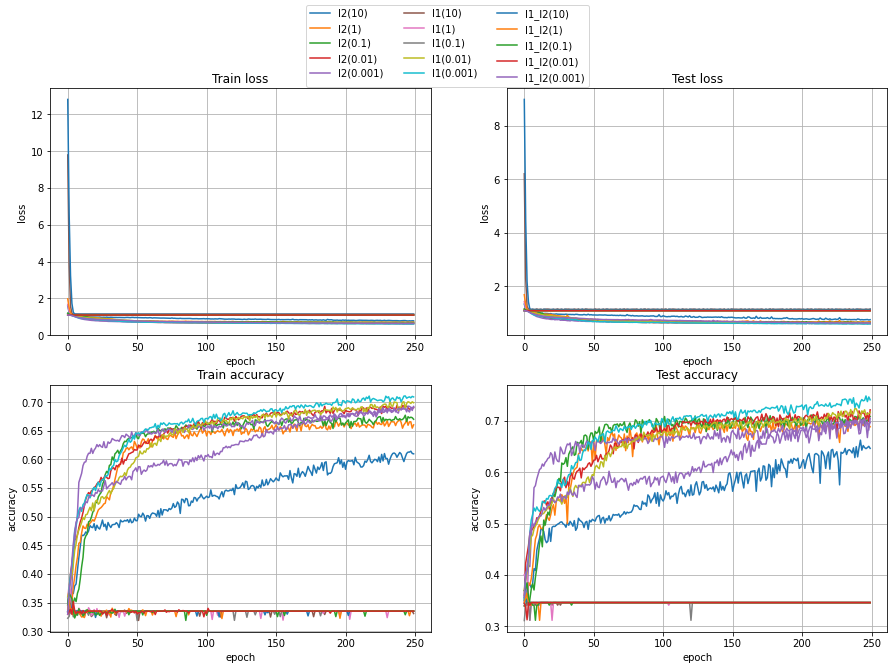

*****************************************************************************************************************
best score: 74.09999966621399  at  l1(0.001)
worst score: 34.65000092983246  at  l1(10)
*****************************************************************************************************************


In [97]:
def get_model(k_reg):
    np.random.seed(12345)
    model = Sequential()
    model.add(Conv1D(                                       
                filters = 5,
                kernel_size = 6,                       
                kernel_regularizer = k_reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))

    model.add(AveragePooling1D(5)) 

    model.add(Conv1D(filters=5,
                     kernel_size=6,
                     activation='relu')
             )

    model.add(Conv1D(filters=5,
                     kernel_size=4,
                     activation='relu')
             )

    model.add(Flatten())                                     
    model.add(Dense(8,activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(N_categ,activation = 'softmax'))
    model.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
                  optimizer = 'adam',
                  metrics = ['accuracy']
                 )
    return model

k_reg = [ 
        regularizers.l2(10),
        regularizers.l2(1),
        regularizers.l2(0.1),
        regularizers.l2(0.01),
        regularizers.l2(0.001),
        regularizers.l1(10),
        regularizers.l1(1),
        regularizers.l1(0.1),
        regularizers.l1(0.01),
        regularizers.l1(0.001),
        regularizers.l1_l2(10),
        regularizers.l1_l2(1),
        regularizers.l1_l2(0.1),
        regularizers.l1_l2(0.01),
        regularizers.l1_l2(0.001),
        ]

vals = ['l2(10)', 'l2(1)', 'l2(0.1)', 'l2(0.01)',
        'l2(0.001)',
        'l1(10)', 'l1(1)', 'l1(0.1)',
        'l1(0.01)',
        'l1(0.001)',
        'l1_l2(10)', 'l1_l2(1)', 'l1_l2(0.1)',
        'l1_l2(0.01)',
        'l1_l2(0.001)',
       ]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0][0].set_title('Train loss')
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('loss')
ax[0][0].grid()
ax[0][1].set_title('Test loss')
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('loss')
ax[0][1].grid()
ax[1][0].set_title('Train accuracy')
ax[1][0].set_xlabel('epoch')
ax[1][0].set_ylabel('accuracy')
ax[1][0].grid()
ax[1][1].set_title('Test accuracy')
ax[1][1].set_xlabel('epoch')
ax[1][1].set_ylabel('accuracy')
ax[1][1].grid()

cvscores = []
for i in tqdm(range(len(k_reg))):
    model = get_model(k_reg[i])
    model.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
                  optimizer = 'adam', metrics = ['accuracy'])

    fit = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data = (x_val,y_val),
                    verbose = 0
                   )
    
    scores = model.evaluate(x_val, y_val, verbose=0)
    cvscores.append(scores[1] * 100)

    fname ='MODEL/model_reg_' + vals[i] +'.h5'
    model.save(fname, save_format='h5')
    
    ax[0][0].plot(fit.history['loss'], label=vals[i])
    ax[0][1].plot(fit.history['val_loss'], label=vals[i])
    ax[1][0].plot(fit.history['accuracy'], label=vals[i])
    ax[1][1].plot(fit.history['val_accuracy'], label=vals[i])

lines_labels = [ax[0][1].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.legend(lines,
           labels,
           loc='upper center',
           ncol=3
          )

plt.show()

print('*' * 113)

print('best score:' , max(cvscores), ' at ', vals[np.argmax(cvscores)])
print('worst score:' , min(cvscores), ' at ', vals[np.argmin(cvscores)])

print('*' * 113)

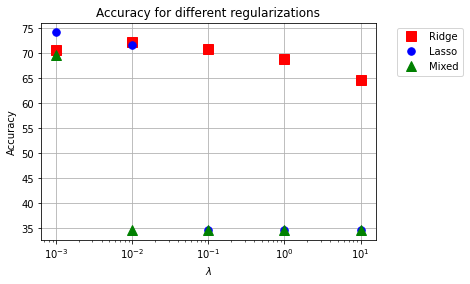

In [140]:
import matplotlib.pyplot as plt
X = [10, 1, 0.1, 0.01, 0.001]
Y1, Y2, Y3 = np.array(cvscores).reshape(3,5)
Z = ['Ridge','Lasso','Mixed']

plt.title('Accuracy for different regularizations')
plt.ylabel('Accuracy')
plt.xlabel('$\lambda$')
plt.xscale('log')
plt.grid()
plt.plot(X, Y1,'rs', markersize = 10, label = Z[0])
plt.plot(X, Y2,'b.', markersize = 15, label = Z[1])
plt.plot(X, Y3,'g^', markersize = 10, label = Z[2])



plt.legend(bbox_to_anchor = (1.05,1))
plt.show()

As we can see some regularizations fail to train the model (accuracy below 35\%). This was expected, given the large values of lambda tested. The best performance are in fact obtained by regularizaion factors of smaller orders.

### Filters visualization

Below we depict the convolutional filters of the first layer of our architecture caring about making a comparison between different lambda values and regularization functions.

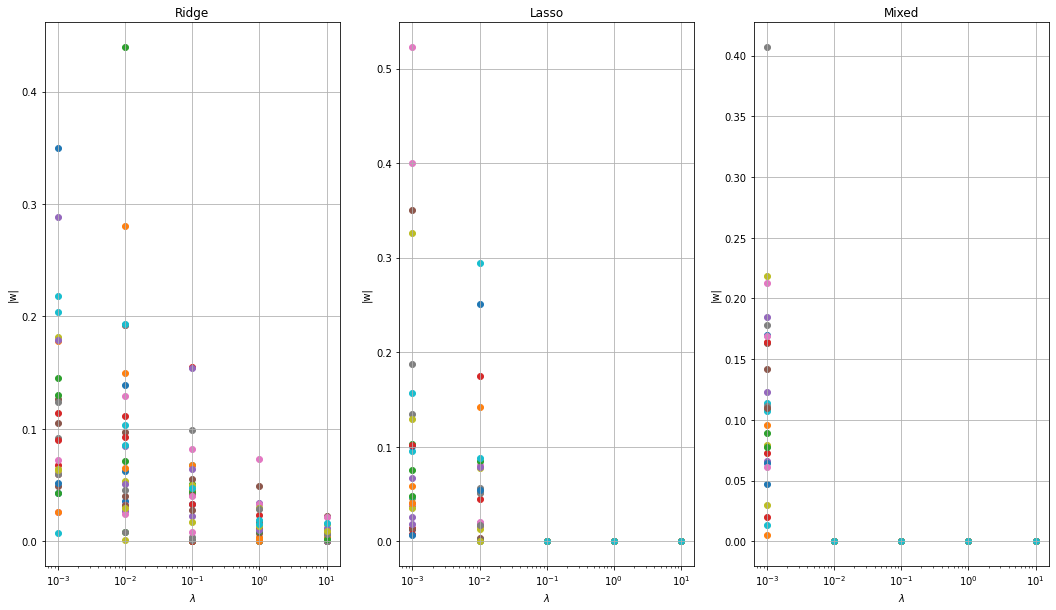

In [126]:
import matplotlib.pyplot as plt
model_names = ['MODEL/model_reg_' + val +'.h5' for val in vals]

total_coeffs = []

for fname in model_names:
    coeffs = []
    model = tensorflow.keras.models.load_model(fname)
    w = abs(model.layers[0].get_weights()[0])
    for i in range(5):
        coeffs += w[:,:,i].T.tolist()
    summ = coeffs[0] + coeffs[1] + coeffs[2] + coeffs[3] + coeffs[4]
    total_coeffs.append(summ)
    
total_coeffs = np.array(total_coeffs)

Ridge = total_coeffs[:5]
Lasso = total_coeffs[5:10]
Mixed = total_coeffs[10:]

lbd = [10, 1, 0.1, 0.01, 0.001]

fig, ax = plt.subplots(1, 3, figsize = (18,10))
for i in range(5):
    for j in range(30):
        ax[0].scatter(lbd[i], Ridge[i,j])
ax[0].set_title('Ridge')
ax[0].set_xlabel('$\lambda$')
ax[0].set_ylabel('|w|')
ax[0].grid()
ax[0].set_xscale('log')

for i in range(5):
    for j in range(30):
        ax[1].scatter(lbd[i], Lasso[i,j])
ax[1].set_title('Lasso')
ax[1].set_xlabel('$\lambda$')
ax[1].set_ylabel('|w|')
ax[1].grid()
ax[1].set_xscale('log')

for i in range(5):
    for j in range(30):
        ax[2].scatter(lbd[i], Mixed[i,j])
ax[2].set_title('Mixed')
ax[2].set_xlabel('$\lambda$')
ax[2].set_ylabel('|w|')
ax[2].grid()
ax[2].set_xscale('log')
    
plt.show()

From this last graph we can infer that, as expected, an increase in the regularization strenght 𝜆 causes a decrease in the weight magnitude, which is sudden for the Mixed and Lasso functions but slower for the Ridge one.

First layer


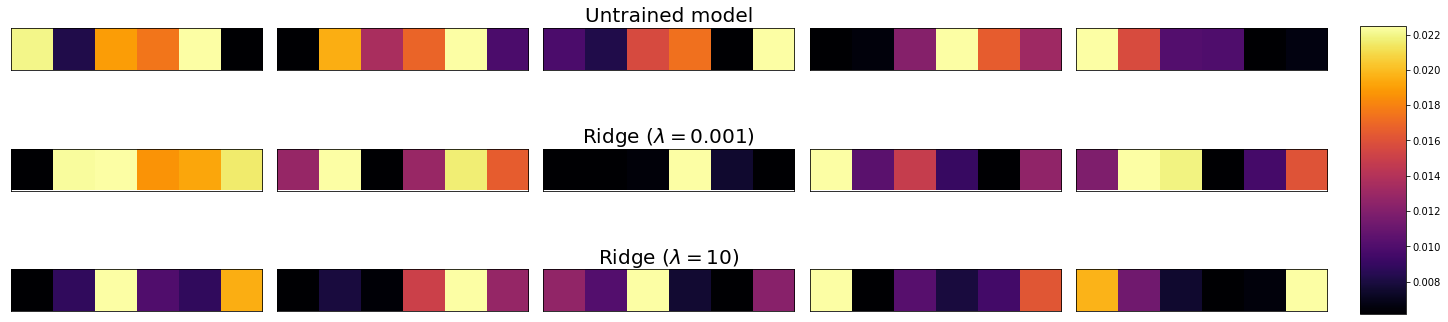

In [142]:
best_loss = regularizers.l2(1e-5)
worst_loss = regularizers.l1_l2(0.01)
cmap = 'inferno'

blank_model = get_model(best_loss)
big_model = tensorflow.keras.models.load_model('MODEL/model_reg_l2(10).h5')
small_model = tensorflow.keras.models.load_model('MODEL/model_reg_l2(0.001).h5')

print('First layer')

blank_filters, blank_biases = blank_model.layers[0].get_weights()
small_filters, small_biases = big_model.layers[0].get_weights()
big_filters, big_biases = small_model.layers[0].get_weights()
n_filters, ix = len(blank_filters[0][0]), 1
fig, ax = plt.subplots(3, n_filters, sharey = True, figsize = (20,5), constrained_layout=True)

for i in range(n_filters):
    # get the filter
    f = abs(np.array(blank_filters[:,:,i]).T)
    sf = abs(np.array(small_filters[:,:,i]).T)
    bf = abs(np.array(big_filters[:,:,i]).T)
    # plot each channel separately
    for j in range(3):
        ax[j][i].set_xticks([])
        ax[j][i].set_yticks([])
    a0 = ax[0][i].imshow(f, cmap=cmap)
    a1 = ax[1][i].imshow(sf, cmap=cmap)
    a2 = ax[2][i].imshow(bf, cmap=cmap)
 
ax[0][2].set_title('Untrained model', fontsize=20)
ax[1][2].set_title('Ridge ($\lambda = 0.001$)', fontsize=20)
ax[2][2].set_title('Ridge ($\lambda = 10$)', fontsize=20)
fig.colorbar(a1, orientation='vertical', ax=ax[:, 4], shrink = 0.8)   
plt.show()

Here we provide a graphical visualization of the absolute value of the five filters of the first layer in the case of Ridge loss for a small and a large value of lambda. As we can notice, in the last row weights are overall smaller, which is expected for a dominant regularization. In the second row instead, the good training assures that the weights mantain a bigger average. 

### Confusion matrix

We finally plot the confusion matrix for the second dataset, obtained from the best model (with Lasso(0.001) regularization) trained for 250 epochs. As we can observe, the label '1' is the best predicted, while the network struggles in determine properly labels '0' and '2'. Nevertheless, the results look promising.

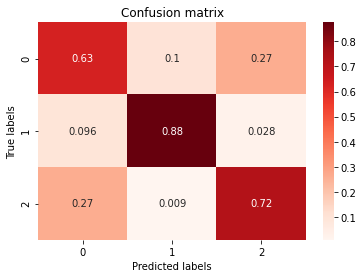

In [143]:
best_after = tensorflow.keras.models.load_model('MODEL/model_reg_l1(0.001).h5')

y_pred_val  = best_after.predict(x_val)

#take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)
confusion_Oz = confusion_matrix(max_y_pred_val,max_y_val, normalize='true') 
sns.heatmap(confusion_Oz, annot = True, cmap = plt.cm.Reds, fmt = '.2g')

plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion matrix')
plt.show()